In [1]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

# Low Pass Filter

possible Options: First order low pass filter, n-th order Butterworth, First order "alpha" IIR Filter (leaky integrator)

In [2]:
f_s = 1000 # 1kHz sampling frequency
T = 1/f_s
f_c = 50

In [3]:
def bode_plot(w, mag, phase):
    """Generate a bode plot for transfer function"""
    
    # Magnitude plot
    plt.semilogx(w, mag)
    plt.ylabel("Magnitude ($dB$)")
    plt.xlim([min(w),max(w)])
    plt.ylim([min(mag),max(mag)])

    # Phase plot
    plt.figure()
    plt.semilogx(w, phase)  # Bode phase plot
    plt.ylabel("Phase ($^\circ$)")
    plt.xlabel("$\omega$ (rad/s)")
    plt.xlim([min(w),max(w)])


## First Order Low Pass

$ H(s) = \frac{\omega_c}{s+\omega_c}$

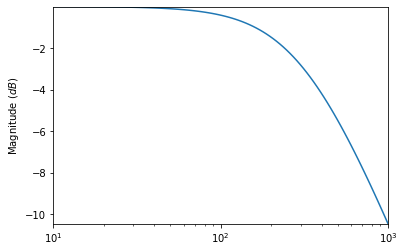

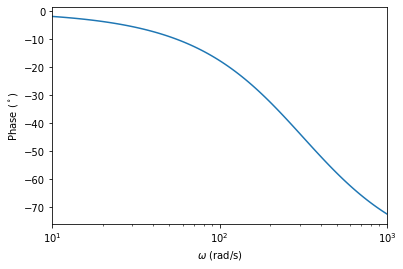

In [4]:
# Low-pass filter
ω_0 = 2*np.pi*f_c;  # pole frequency (rad/s)
num = ω_0         # transfer function numerator coefficients
den = [1, ω_0]    # transfer function denominator coefficients
lowpass = signal.TransferFunction(num,den) # Transfer function

w, mag, phase = lowpass.bode()

bode_plot(w, mag, phase)

not digitalized yet, needs still to be done..

## First order IIR Filter (leaky integrator)

$ H(z) = \frac{1 - \alpha}{1-\alpha z^{-1}}, \quad \text{with}\; \alpha = \frac{t_\mathrm{c}}{T + t_\mathrm{c}}$

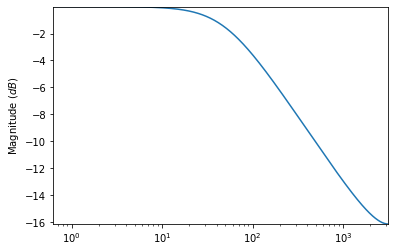

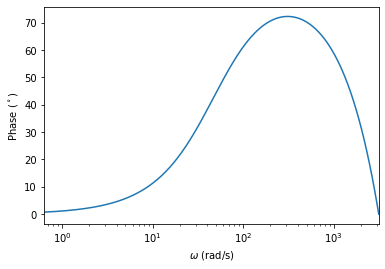

In [5]:
t_c = 1/f_c
α = t_c / (T + t_c)
Θ = 2* np.pi * np.geomspace( 1e-4, f_s/2000, 500 )
mag = 10 * np.log10((1 - α) / np.sqrt( (1 + α**2) - 2 * α * np.cos(Θ)))
phase = np.rad2deg(np.arctan2( α * np.sin(Θ), 1 - α * np.cos(Θ)))

bode_plot(f_s*Θ, mag, phase)

ugly artifacts in high frequency domain, though ready to be implemented and used in px4

In [6]:
def get_first_order_iir_low_pass(T, t_c):
    y_n = 0.0
    
    t_c = 1/f_c
    α = T / (T + t_c)
    
    def filter(x_n):
        nonlocal y_n, α
        
        y_n = (1-α) * y_n + α * x_n
        
        return y_n
    return filter


## Generate test data

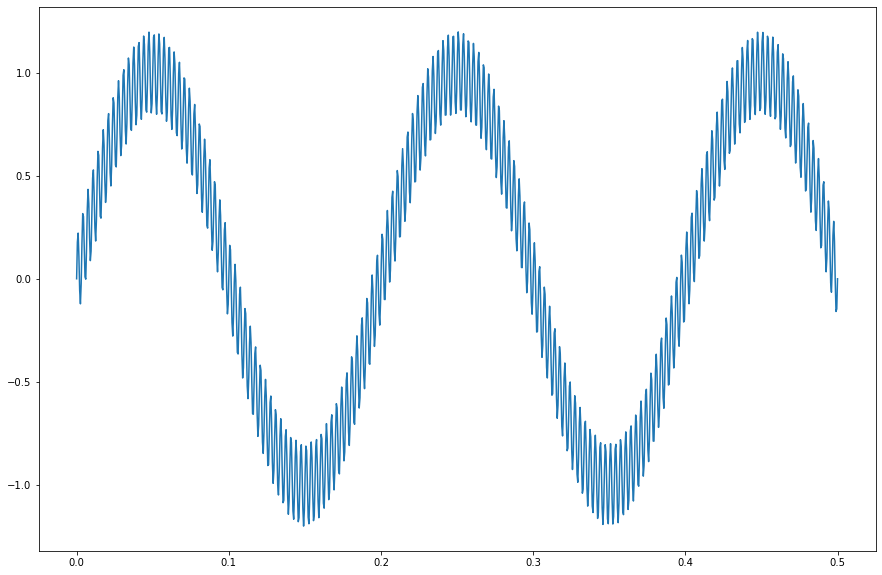

In [7]:
x = np.linspace(0, 500*T, 1000)
f1 = 5
f2 = 300

# base sine
y1 = np.sin(2*np.pi*f1*x)
# disturbance sine
y2 = 0.2 * np.sin(2*np.pi*f2*x)
#combination
y3 = y1 + y2

plt.figure(figsize=(15,10))
plt.plot(x, y3)

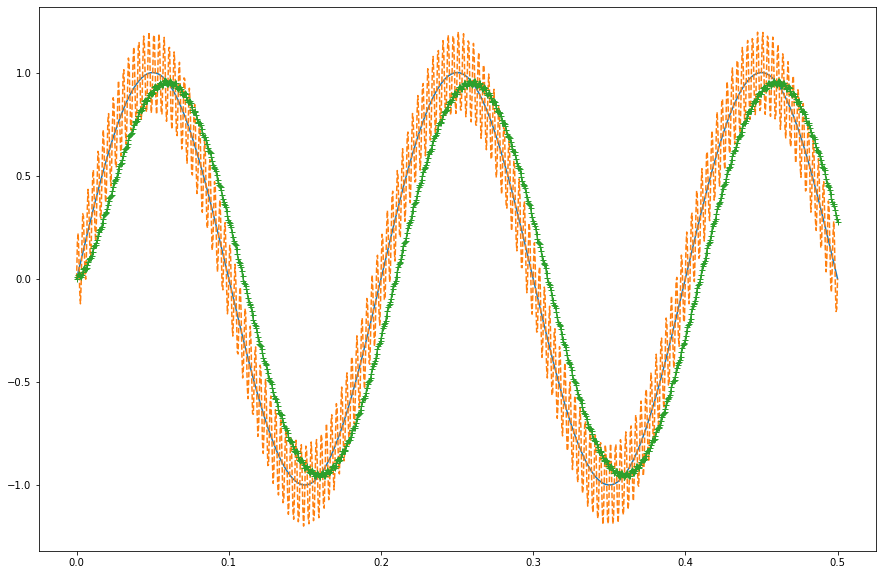

In [8]:
lp = get_first_order_iir_low_pass(T, 1/50)

y4 = np.array([lp(ay) for ay in y3])

plt.figure(figsize=(15,10))
plt.plot(x, y1)
plt.plot(x, y3, '--')
plt.plot(x, y4, '+-')

In [9]:
data = np.vstack((y3, y4)).T

with open("test_low_pass_data.inc", "w") as afile:
    afile.write(f"const float test_data[{data.shape[0]}][{data.shape[1]}] = {{\n")
    for row in data:
        afile.write(("\t{{" + len(row)*"{:2.16f}f, " +"}},\n").format(*row))

    afile.write("};\n")
    